###**Andrew Renninger**
### Final

In [28]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


## Wrangling



In [0]:
from google.colab import auth
auth.authenticate_user()

In [30]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=lFXAgOtOX0gE5VG46Kq-KjPzZzEv_mAjGsOekDX3Xf8&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/zQGRdhgjMQ98YkdXSANBtMEJC7ybcwbpkmRHcfLdEmn_LnY7AI89jd4

Successfully saved authorization token.


In [31]:
import tensorflow as tf
import folium

print(tf.__version__)
print(folium.__version__)

2.2.0-rc3
0.8.3


In [0]:
FOLDER = 'final'
TRAINING_BASE = 'training'
EVAL_BASE = 'testing'

opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
thermalBands = ['B10', 'B11']

BANDS = opticalBands + thermalBands

RESPONSE = ['landcover', 'impervious']

In [0]:
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(opticalBands).gt(0).And(
          image.select(opticalBands).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)
  return image.select(opticalBands).divide(10000).addBands(
          image.select(thermalBands).divide(10).clamp(273.15, 373.15)
            .subtract(273.15).divide(100)).updateMask(mask)

In [46]:
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
srtm = ee.Image('USGS/SRTMGL1_003')

winter = ee.Filter.calendarRange(11, 2, 'month')
summer = ee.Filter.calendarRange(5, 8, 'month')

winterimage = l8sr.filterDate('2015-01-01', '2017-12-31').filter(winter).map(maskL8sr).median()
summerimage = l8sr.filterDate('2015-01-01', '2017-12-31').filter(summer).map(maskL8sr).median()

mapid = winterimage.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[40, -75.3])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite (winter)',
  ).add_to(map)

mapid = summerimage.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite (summer)',
  ).add_to(map)

mapid = winterimage.getMapId({'bands': ['B10'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal (winter)',
  ).add_to(map)

mapid = summerimage.getMapId({'bands': ['B10'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal (summer)',
  ).add_to(map)

map.add_child(folium.LayerControl())
map


In [38]:
lc = ee.Image('USGS/NLCD/NLCD2016').select('landcover')
lc = lc.float()

im = ee.Image('USGS/NLCD/NLCD2016').select('impervious')
im = im.divide(100).float()

mapid = im.getMapId({'min': 0, 'max': 1})
map = folium.Map(location=[40, -75.3])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='nlcd impervious',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [0]:
light1 = winterimage.select(BANDS)
light2 = summerimage.select(BANDS)

slope = ee.Terrain.slope(srtm) 

nlcd = lc.addBands(im)

composite = nlcd.addBands([slope, light1, light2])

In [40]:
mapid = composite.getMapId({'bands': ['slope'], 'min': 0, 'max': 50})
map = folium.Map(location=[40, -75.3])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)

map

In [0]:
composite = composite.float()

In [42]:
trainingPolys = ee.FeatureCollection('users/asrenninger/training')
evalPolys = ee.FeatureCollection('users/asrenninger/testing')

polyImage = ee.Image(0).byte().paint(trainingPolys, 1).paint(evalPolys, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['cyan', 'magenta']})
map = folium.Map(location=[38., -100.], zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [0]:
trainingPolysList = trainingPolys.toList(trainingPolys.size())
evalPolysList = evalPolys.toList(evalPolys.size())

In [0]:
for g in range(trainingPolys.size().getInfo()):
  desc = TRAINING_BASE + '_comp_' + str(g)
  task = ee.batch.Export.image.toDrive(
    image = composite,
    folder = FOLDER,
    fileNamePrefix = desc,
    description = desc, 
    region = ee.Feature(trainingPolysList.get(g)).geometry(), 
    scale = 30, 
  )
  task.start()

In [0]:
for g in range(evalPolys.size().getInfo()):
  desc = EVAL_BASE + '_comp_' + str(g)
  task = ee.batch.Export.image.toDrive(
    image = composite,
    folder = FOLDER,
    fileNamePrefix = desc,
    description = desc, 
    region = ee.Feature(evalPolysList.get(g)).geometry(), 
    scale = 30, 
  )
  task.start()

## Modelling

In [1]:
!pip install tifffile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
directory = '/content/drive/My Drive/final/patches'
path = directory + '/training_comp_0.tif'

In [0]:
import tifffile as tiff

In [5]:
img = tiff.imread(path)
img.shape

(6410, 6690, 21)

In [0]:
import numpy as np

In [0]:
img[np.isnan(img)] = 0

In [0]:
import matplotlib
import matplotlib.pyplot as plt

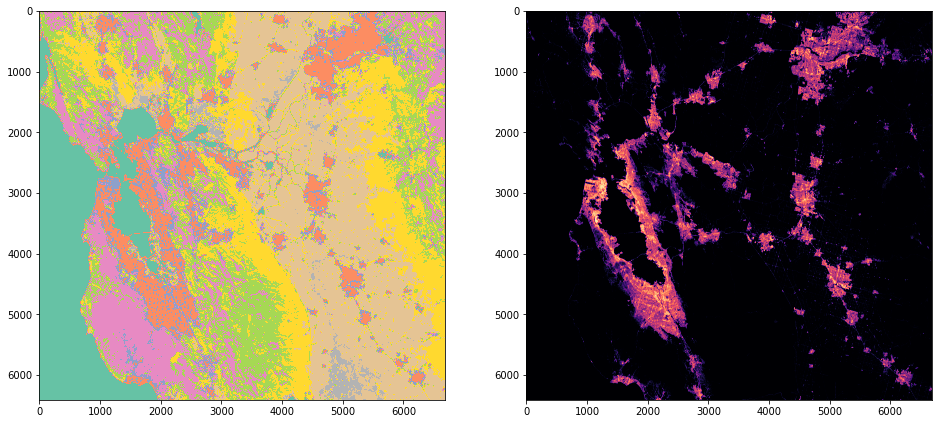

In [10]:
fig, axs = plt.subplots(1, 2, figsize = [16, 16])

axs[0].imshow(img[:, :, 0], cmap = 'Set2')
axs[1].imshow(img[:, :, 1], cmap = 'magma')

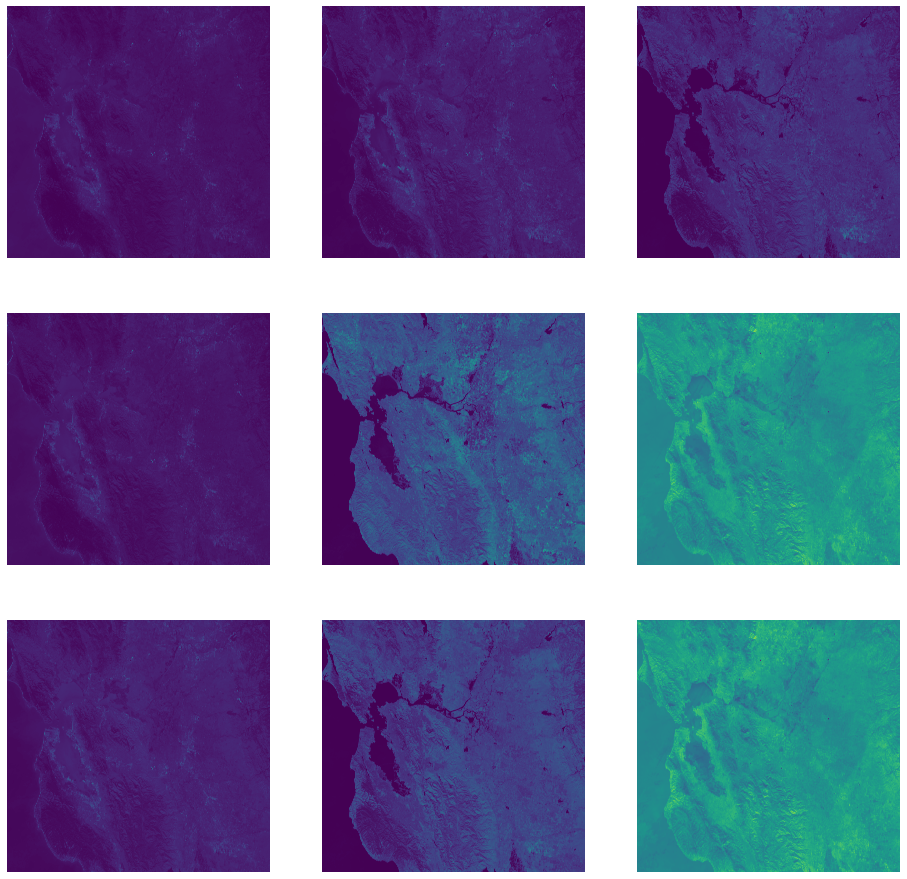

In [11]:
fig, axs = plt.subplots(3, 3, figsize = [16, 16])

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
      slot = slot = i*3+j
      axs[j, i].axis('off')
      axs[j, i].imshow(img[:,:, slot + 3], cmap = 'viridis')
        
plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
from sklearn.feature_extraction import image

In [153]:
patches = image.extract_patches_2d(img, (128, 128), max_patches = 1000, random_state = 42)
patches.shape

(1000, 128, 128, 21)

In [154]:
masks = patches[:, :, :, :1]
masks.shape

(1000, 128, 128, 1)

In [0]:
flat = masks.flatten()

flat = np.where((flat < 21) | (flat > 24), 0, flat)
flat = np.where((flat > 20) & (flat < 25), 1, flat)

square = flat.reshape(masks.shape)

In [155]:
patches = patches[:, :, :, 2:]
patches.shape

(1000, 128, 128, 19)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(patches, square, test_size = 0.4, random_state = 42)

In [0]:
from numpy import random

Text(0.5, 1.0, 'Landcover')

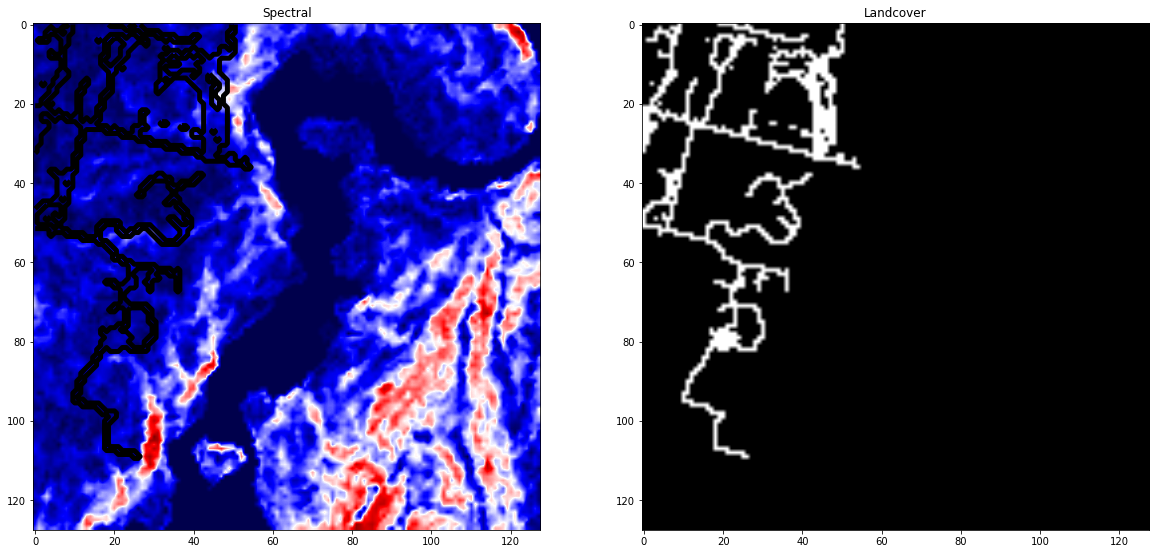

In [171]:
idx = random.randint(0, len(X_train))
has_mask = y_train[idx].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[idx, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[idx].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Spectral')

ax2.imshow(y_train[idx].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Landcover')

In [0]:
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
input_img = Input((128, 128, 19), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [174]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 19) 0                                            
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, 128, 128, 16) 2752        img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_146 (BatchN (None, 128, 128, 16) 64          conv2d_154[0][0]                 
__________________________________________________________________________________________________
activation_146 (Activation)     (None, 128, 128, 16) 0           batch_normalization_146[0][0]    
____________________________________________________________________________________________

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [176]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 600 samples, validate on 400 samples
Epoch 1/50
600/600 [==============================] - 4s 7ms/step - loss: 0.5193 - accuracy: 0.7762 - val_loss: 0.6666 - val_accuracy: 0.7389

Epoch 00001: val_loss improved from inf to 0.66658, saving model to model-tgs-salt.h5
Epoch 2/50
600/600 [==============================] - 2s 3ms/step - loss: 0.4044 - accuracy: 0.8489 - val_loss: 1.3824 - val_accuracy: 0.4185

Epoch 00002: val_loss did not improve from 0.66658
Epoch 3/50
600/600 [==============================] - 2s 3ms/step - loss: 0.3153 - accuracy: 0.8945 - val_loss: 1.9183 - val_accuracy: 0.7439

Epoch 00003: val_loss did not improve from 0.66658
Epoch 4/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2787 - accuracy: 0.9053 - val_loss: 0.8710 - val_accuracy: 0.7815

Epoch 00004: val_loss did not improve from 0.66658
Epoch 5/50
600/600 [==============================] - 2s 3ms/step - loss: 0.2802 - accuracy: 0.9036 - val_loss: 1.4998 - val_accuracy: 0.6565



In [73]:
resp = img[:, :, 0].flatten()

resp = np.where((resp < 21) | (resp > 24), 0, resp)
resp = np.where((resp > 20) & (resp < 25), 1, resp)
print(resp.shape)

pred = np.zeros([resp.shape[0], 19])
print(pred.shape)

(42882900,)
(42882900, 19)


In [74]:
np.unique(resp)

array([0., 1.], dtype=float32)

In [0]:
from sklearn import preprocessing

In [0]:
for i in np.arange(0, pred.shape[1]):
  data = img[:, :, i + 2]
  
  print(i + 2)

  scaler = preprocessing.StandardScaler().fit(data)
  scaled = scaler.transform(data)
  pred[:, i] = scaled.flatten()

In [0]:
idx = np.random.randint(0, len(resp), 100000)

resp = resp[idx]
pred = pred[idx, :]

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(pred, resp, test_size = 0.5, random_state = 42)

In [0]:
from keras.utils import to_categorical
from keras.utils import np_utils

In [0]:
num_classes = 2

y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D, AveragePooling2D

EPOCH = 100
BATCH = 32 

In [83]:
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(19,)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               2560      
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)              

In [0]:
from keras.optimizers import SGD

In [0]:
sgd = SGD(lr = 0.01, momentum = 0.9, nesterov = True)

In [0]:
model.compile(optimizer = sgd,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [87]:
history = model.fit(X_train, y_train,
                    epochs = EPOCH,
                    batch_size = BATCH,
                    validation_data = (X_test, y_test))

Train on 50000 samples, validate on 50000 samples
Epoch 1/100
50000/50000 [==============================] - 10s 200us/step - loss: 0.2638 - accuracy: 0.9083 - val_loss: 0.2142 - val_accuracy: 0.9260
Epoch 2/100
50000/50000 [==============================] - 10s 196us/step - loss: 0.2258 - accuracy: 0.9227 - val_loss: 0.2062 - val_accuracy: 0.9256
Epoch 3/100
50000/50000 [==============================] - 10s 196us/step - loss: 0.2170 - accuracy: 0.9248 - val_loss: 0.2047 - val_accuracy: 0.9297
Epoch 4/100
50000/50000 [==============================] - 10s 195us/step - loss: 0.2135 - accuracy: 0.9264 - val_loss: 0.2019 - val_accuracy: 0.9278
Epoch 5/100
50000/50000 [==============================] - 10s 196us/step - loss: 0.2075 - accuracy: 0.9274 - val_loss: 0.1988 - val_accuracy: 0.9288
Epoch 6/100
50000/50000 [==============================] - 10s 196us/step - loss: 0.2049 - accuracy: 0.9281 - val_loss: 0.2037 - val_accuracy: 0.9270
Epoch 7/100
50000/50000 [=========================

In [88]:
score = model.evaluate(X_test, y_test, verbose = 0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.176293572204113
Test accuracy:  0.9366000294685364


In [0]:
from sklearn import preprocessing

In [7]:
directory = '/content/drive/My Drive/final/patches'

train = np.empty((0, 150, 21))

for i in np.arange(0, 4):
  file = ("/training_comp_{}.tif".format(i))
  path = directory + file
  print(file)
  
  img = tiff.imread(path)
  img[np.isnan(img)] = 0

  img = img[:, np.random.randint(0, img.shape[1], 150), :]
  img = img[np.random.randint(0, img.shape[0], 150), :, :]

  train = np.concatenate((dat, img))

/training_comp_0.tif
/training_comp_1.tif
/training_comp_2.tif
/training_comp_3.tif


In [8]:
test = np.empty((0, 150, 21))

for i in np.arange(0, 4):
  file = ("/testing_comp_{}.tif".format(i))
  path = directory + file
  print(file)
  
  img = tiff.imread(path)
  img[np.isnan(img)] = 0

  img = img[:, np.random.randint(0, img.shape[1], 150), :]
  img = img[np.random.randint(0, img.shape[0], 150), :, :]

  test = np.concatenate((dat, img))

/testing_comp_0.tif
/testing_comp_1.tif
/testing_comp_2.tif
/testing_comp_3.tif


In [9]:
print(dat.shape)

(1200, 150, 21)


In [10]:
resp = dat[:, :, 0].flatten()

resp = np.where((resp < 21) | (resp > 24), 0, resp)
resp = np.where((resp > 20) & (resp < 25), 1, resp)
print(resp.shape)

pred = np.zeros([resp.shape[0], 19])
print(pred.shape)

(180000,)
(180000, 19)


In [0]:
from sklearn import preprocessing

In [0]:
for i in np.arange(0, pred.shape[1]):
  data = dat[:, :, i + 2]

  scaler = preprocessing.StandardScaler().fit(data)
  scaled = scaler.transform(data)
  pred[:, i] = scaled.flatten()

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(pred, resp, test_size = 0.5, random_state = 42)

In [15]:
from keras.utils import to_categorical
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
num_classes = 2

y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D, AveragePooling2D

EPOCH = 100
BATCH = 32 

In [18]:
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(19,)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2560      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

In [0]:
from keras.optimizers import SGD

In [0]:
sgd = SGD(lr = 0.01, momentum = 0.9, nesterov = True)

In [0]:
model.compile(optimizer = sgd,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [22]:
history = model.fit(X_train, y_train,
                    epochs = EPOCH,
                    batch_size = BATCH,
                    validation_data = (X_test, y_test))

Train on 90000 samples, validate on 90000 samples
Epoch 1/100
90000/90000 [==============================] - 15s 168us/step - loss: 0.2937 - accuracy: 0.8900 - val_loss: 0.2586 - val_accuracy: 0.9036
Epoch 2/100
90000/90000 [==============================] - 13s 149us/step - loss: 0.2618 - accuracy: 0.9046 - val_loss: 0.2625 - val_accuracy: 0.9071
Epoch 3/100
90000/90000 [==============================] - 13s 146us/step - loss: 0.2567 - accuracy: 0.9053 - val_loss: 0.2501 - val_accuracy: 0.9085
Epoch 4/100
90000/90000 [==============================] - 13s 149us/step - loss: 0.2528 - accuracy: 0.9067 - val_loss: 0.2497 - val_accuracy: 0.9072
Epoch 5/100
90000/90000 [==============================] - 14s 156us/step - loss: 0.2494 - accuracy: 0.9084 - val_loss: 0.2481 - val_accuracy: 0.9066
Epoch 6/100
90000/90000 [==============================] - 14s 157us/step - loss: 0.2480 - accuracy: 0.9083 - val_loss: 0.2470 - val_accuracy: 0.9081
Epoch 7/100
90000/90000 [=========================

In [23]:
score = model.evaluate(X_test, y_test, verbose = 0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.23064599973890518
Test accuracy:  0.9146222472190857


In [0]:
import cv2
from PIL import Image, ImageFilter

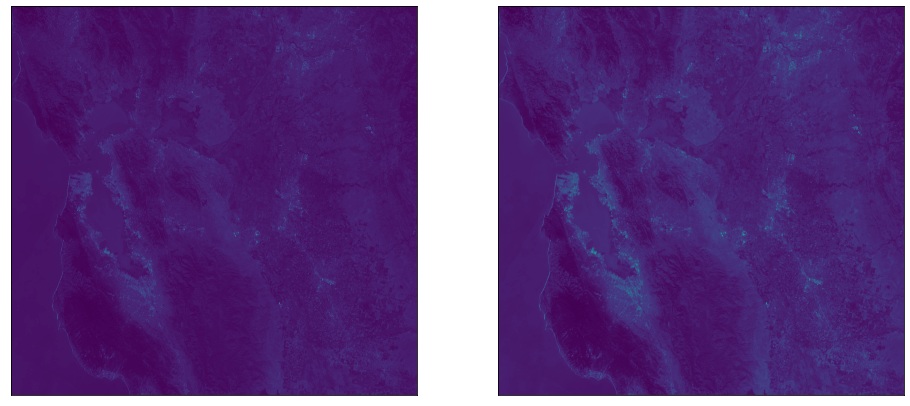

In [0]:
kernel = 9 

old_image = img[:, :, 2]
new_image = cv2.blur(old_image, (kernel, kernel))

plt.figure(figsize=(16, 16))

plt.subplot(121), plt.imshow(old_image)
plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(new_image)
plt.xticks([]), plt.yticks([])

plt.show()

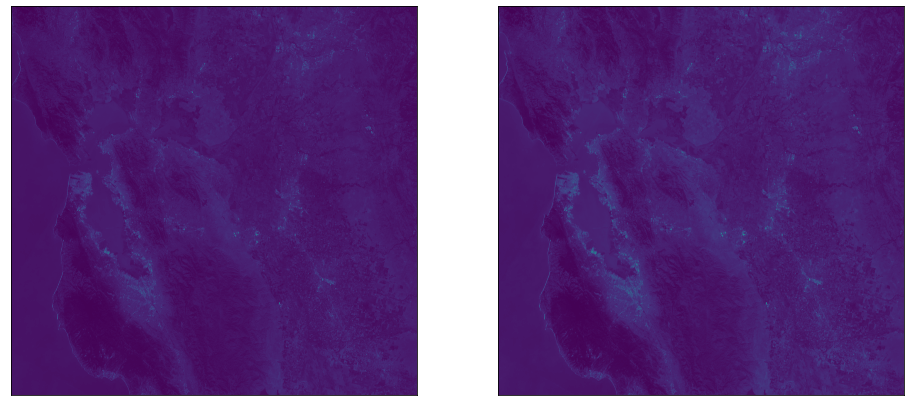

In [0]:
kernel = 9 

old_image = img[:, :, 2]
new_image = new_image = cv2.bilateralFilter(old_image, 9, 9, 9)

plt.figure(figsize=(16, 16))

plt.subplot(121), plt.imshow(old_image)
plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(new_image)
plt.xticks([]), plt.yticks([])

plt.show()

Patch as input, pixel as output / 
Semantic segmentation (U-Net) / 
Image in-Image out /
Existing model /